# SARIMAX
SARIMA: (S)easonal differencing + (A)uto(R)egression + d(I)fferencing + (M)oving (A)verage + e(X)ogenous regressor 

- we start with ARIMA 
- then try SARIMA
- and finally SARIMAX

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn import metrics

# import self writted modules
from preprocess import join_sales_products, set_datetime_index
from evaluation.metrics import count_overstock, count_understock, total_value_understock, print_relevant_metrics
from evaluation.metrics import print_standard_regression_metrics, monetary_model_cost, under_overstock_balance_loss
from evaluation.visualization import plot_forecast_interval, gaussian_confidence_bands
from models.sarimax import order_selection


path = '~/Documents/interview_challenge/amorelie_task/data/'
df_sales = pd.read_csv(path + 'sales.csv')
df_products = pd.read_csv(path + 'products.csv')

df = join_sales_products(df_sales, df_products)
df = set_datetime_index(df)

df_sku = df[df['product_id'] == 46688]  
y = df_sku['units_sold']

# aggreage daily data
sold_daily = df_sku['units_sold'].groupby(pd.Grouper(freq='D')).sum()
prices_mean_daily = df_sku['selling_price'].groupby(pd.Grouper(freq='D')).mean() 

n_test = 35  # 20 weeks of prediction

train = sold_daily.iloc[:-(n_test)]
test = sold_daily.tail(n_test)
price_mean_test = prices_mean_daily.tail(n_test)

# First ARIMA fit

In [2]:
model = ARIMA(train, order=(5,1,7))
model_fit = model.fit()
yhat, sigma_hat, confident_bounds = model_fit.forecast(n_test)

/home/dennis/Envs/venv3/local/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [3]:
model_name = 'ARIMA (5,1,7) 46688'
print_relevant_metrics(test, yhat, model_name,  price_mean_test)

-----------------------ARIMA (5,1,7) 46688: Evaluation on y set ----------------------------------
Count of Overstocked items: 124.38001722147585
Count of Understocked items: 46.20991096069152
Total_Value of Understocked Items: 541.2720903862333
Estimated Monetary Costs: 178.5072262600992
Under/Overstocking Balance Loss: 586.4791268283911
MSE: 35.954580406012035
RMSE: 5.996213839249901
Median Absolut Error 4.555280870891817
MAP: 4.873997948061925
R2: 0.10848593236651427


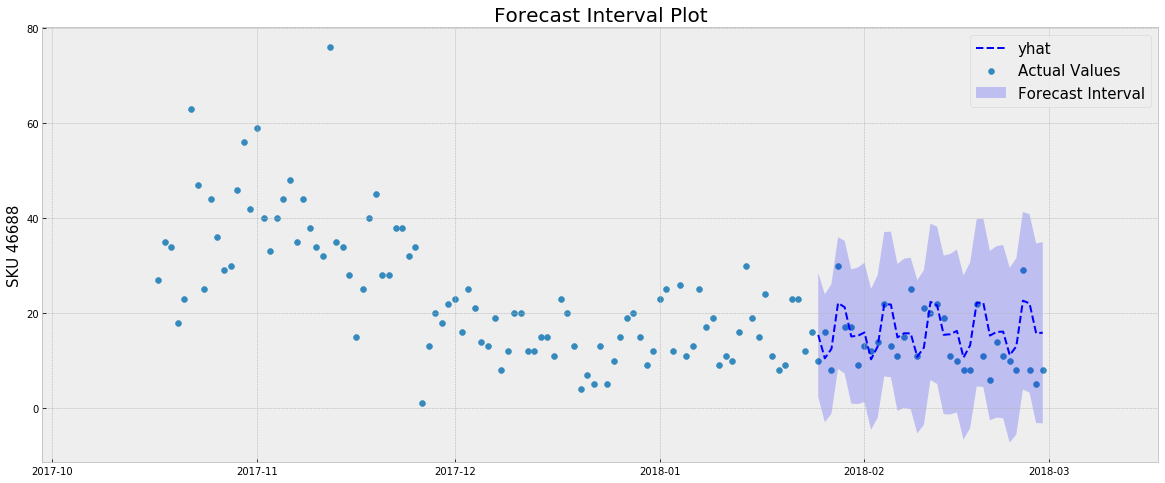

In [4]:
df_interval = pd.DataFrame({
        'y': test,
        'yhat': yhat,
        'sigma_hat': sigma_hat,
        'lower': confident_bounds[:,0],
        'upper': confident_bounds[:,1]
    })
plot_forecast_interval(df_interval, sold_daily.tail(135), ts_name='SKU 46688')
plt.show()

# SARIMA

In [21]:
params = {'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 7)}

model = SARIMAX(train, **params)
model_fit = model.fit()
yhat = model_fit.forecast(n_test)

In [22]:
model_name = 'SARIMA 46688'
print_relevant_metrics(test, yhat, model_name,  price_mean_test)

-----------------------SARIMA 46688: Evaluation on y set ----------------------------------
Count of Overstocked items: 86.4767984062857
Count of Understocked items: 59.00450114803175
Total_Value of Understocked Items: 691.1393901139452
Estimated Monetary Costs: 155.59073741768023
Under/Overstocking Balance Loss: 676.5218098866033
MSE: 25.554698663611457
RMSE: 5.055165542651542
Median Absolut Error 3.4225657826868527
MAP: 4.156608558694785
R2: 0.36635685647064953


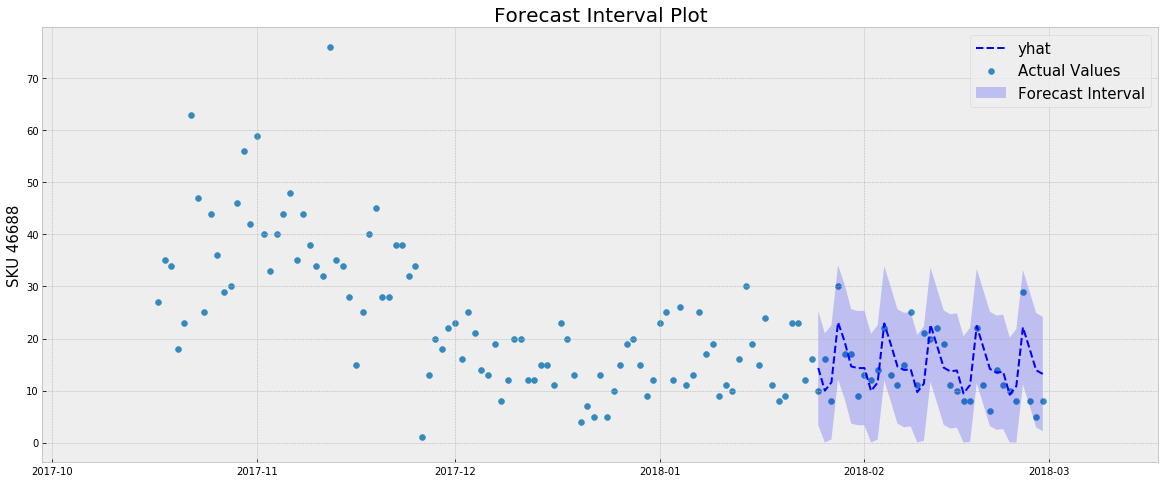

In [11]:
sigma_resid = np.full(n_test, np.std(model_fit.resid))
lower, upper = gaussian_confidence_bands(yhat, sigma_resid, alpha=0.95)

df_interval = pd.DataFrame({
        'y': test,
        'yhat': yhat,
        'sigma_hat': sigma_resid,
        'lower': lower,
        'upper': upper
    })
plot_forecast_interval(df_interval, sold_daily.tail(135), ts_name='sold units for product id 46688')
plt.show()

### Tune SARIMA
- according to R2 or to business metric?

In [30]:
from model.sarimax import order_selection

params = {
    'order': [(5,1,1), (10,1,1), (2,1,1), (1,1,10)],
    'seasonal_order': [(5,1,1,7), (1,0,1,7), (10,1,1,7), (1,1,10,7)]
}

order_selection(train, test, params, loss_func=under_overstock_balance_loss)

{'order': (5, 1, 1), 'seasonal_order': (5, 1, 1, 7)}
model fit sucessful
654.7371472991235
{'order': (5, 1, 1), 'seasonal_order': (1, 0, 1, 7)}
model fit sucessful
688.7711923738756
{'order': (5, 1, 1), 'seasonal_order': (10, 1, 1, 7)}
model fit sucessful
764.3333083224964
{'order': (5, 1, 1), 'seasonal_order': (1, 1, 10, 7)}
model fit sucessful
771.3472312620893
{'order': (10, 1, 1), 'seasonal_order': (5, 1, 1, 7)}
model fit sucessful
630.0898251420181
{'order': (10, 1, 1), 'seasonal_order': (1, 0, 1, 7)}
model fit sucessful
468.9617742561949
{'order': (10, 1, 1), 'seasonal_order': (10, 1, 1, 7)}
model fit sucessful
973.7697162247118
{'order': (10, 1, 1), 'seasonal_order': (1, 1, 10, 7)}
model fit sucessful
749.8873675123441
{'order': (2, 1, 1), 'seasonal_order': (5, 1, 1, 7)}
model fit sucessful
663.5018425277952
{'order': (2, 1, 1), 'seasonal_order': (1, 0, 1, 7)}
model fit sucessful
692.8395355609567
{'order': (2, 1, 1), 'seasonal_order': (10, 1, 1, 7)}
model fit sucessful
746.4744

({'order': (10, 1, 1), 'seasonal_order': (1, 0, 1, 7)}, 468.9617742561949)

-----------------------Tuned SARIMA 46688: Evaluation on y set ----------------------------------
Count of Overstocked items: 74.83955680920172
Count of Understocked items: 67.50478107031424
Total_Value of Understocked Items: 790.7060022702806
Estimated Monetary Costs: 153.9101570362298
Under/Overstocking Balance Loss: 749.8873675123441
MSE: 24.622914359003246
RMSE: 4.962148159719059
Median Absolut Error 3.2789238687694677
MAP: 4.066981082271885
R2: 0.38946097300261173


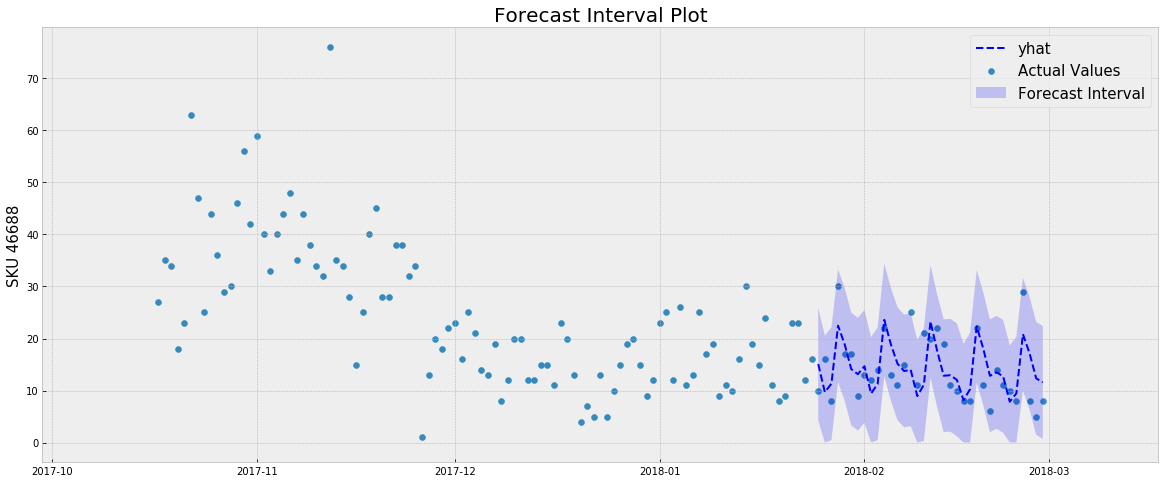

In [54]:
# Best ARIMA{'order': (10, 1, 1), 'seasonal_order': (1, 0, 1, 7)} Loss=468.962
# Best ARIMA{'order': (10, 1, 1), 'seasonal_order': (1, 1, 10, 7)} R2=0.38946097300261173
 
# refit
params = {'order': (10, 1, 1), 'seasonal_order': (1, 1, 10, 7)}

model = SARIMAX(train, **params)
model_fit = model.fit()
yhat = model_fit.forecast(n_test)

model_name = 'Tuned SARIMA 46688'
print_relevant_metrics(test, yhat, model_name,  price_mean_test)

sigma_resid = np.full(n_test, np.std(model_fit.resid))
lower, upper = gaussian_confidence_bands(yhat, sigma_resid, alpha=0.95)

df_interval = pd.DataFrame({
        'y': test,
        'yhat': yhat,
        'sigma_hat': sigma_resid,
        'lower': lower,
        'upper': upper
    })
plot_forecast_interval(df_interval, sold_daily.tail(135), ts_name='sold units for product id 46688')
plt.show()

## Adding Exogenous Regressors 
Need to be known for the future horizon! So at the data set at hand we could only create promotion dummy as exogenous variable. Problem: Rarely any promotion happen! For 46688 only one promotion in 3 year has happened

In [47]:
# promotion
promotion = df_sku[(df_sku['promotion_dummy_1'] == 'Yes') | (df_sku['promotion_dummy_2'] == 'Yes')]
promotion

,product_id,website,date,units_sold,selling_price,promotion_dummy_1,promotion_dummy_2,brand,main_category_id,parent_category_id
date,,,,,,,,,,
2017-03-19,46688,2,2017-03-19,3,12.945,Yes,No,1,198,5
2017-03-19,46688,3,2017-03-19,18,10.900,Yes,No,1,198,5
2017-03-19,46688,1,2017-03-19,7,10.900,Yes,No,1,198,5


## SARIMA for all SKUs
- Tuning: minimize MSE (business metric would be better, but without knowing true cost it does not make too much sense)

14530
-----------------------naive model for 14530: Evaluation on y set ----------------------------------
Count of Overstocked items: 16
Count of Understocked items: 27
Total_Value of Understocked Items: 307.98
Estimated Monetary Costs: 46.798
Under/Overstocking Balance Loss: 286
MSE: 2.7142857142857144
RMSE: 1.647508942095828
Median Absolut Error 1.0
MAP: 1.2285714285714286
R2: -0.5788224121557453
1.6894598844439366
1.674878184758327
Best ARIMA{'order': (10, 1, 1), 'seasonal_order': (5, 1, 1, 7)} Loss=1.675
-----------------------Tuned SARIMA for 14530: Evaluation on y set ----------------------------------
Count of Overstocked items: 16.0
Count of Understocked items: 20.0
Total_Value of Understocked Items: 228.13333333333333
Estimated Monetary Costs: 38.81333333333333
Under/Overstocking Balance Loss: 216.0
MSE: 1.7142857142857142
RMSE: 1.3093073414159542
Median Absolut Error 1.0
MAP: 1.0285714285714285
R2: 0.002849002849002913


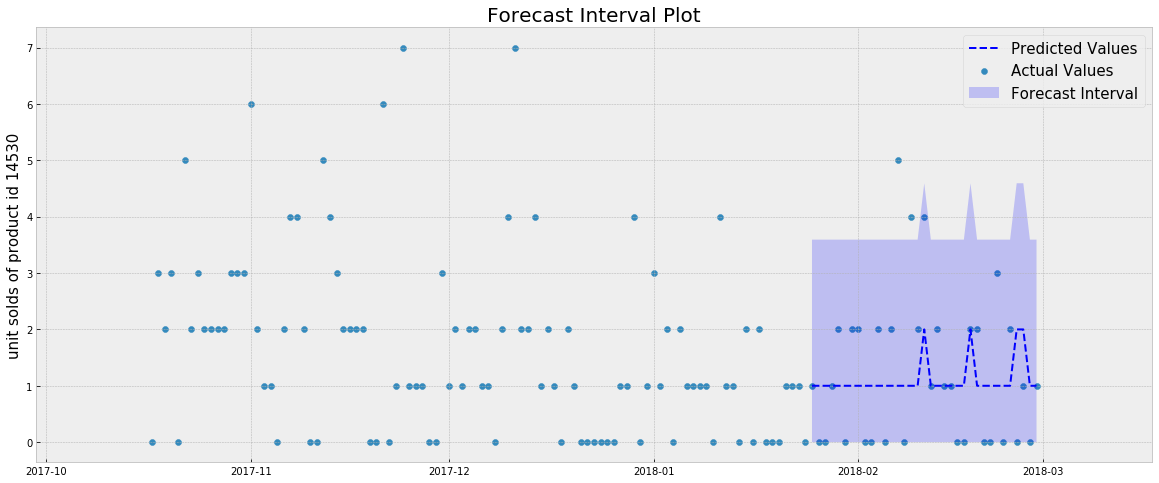

14554
-----------------------naive model for 14554: Evaluation on y set ----------------------------------
Count of Overstocked items: 36
Count of Understocked items: 34
Total_Value of Understocked Items: 420.4666666666667
Estimated Monetary Costs: 78.04666666666667
Under/Overstocking Balance Loss: 376
MSE: 7.085714285714285
RMSE: 2.6619005025947695
Median Absolut Error 2.0
MAP: 2.0
R2: -0.8650623119896861
5.988220203914348
5.925280242659639
Best ARIMA{'order': (1, 1, 10), 'seasonal_order': (10, 1, 1, 7)} Loss=5.925
-----------------------Tuned SARIMA for 14554: Evaluation on y set ----------------------------------
Count of Overstocked items: 40.0
Count of Understocked items: 28.0
Total_Value of Understocked Items: 346.26666666666665
Estimated Monetary Costs: 74.62666666666667
Under/Overstocking Balance Loss: 320.0
MSE: 5.828571428571428
RMSE: 2.4142434484888695
Median Absolut Error 2.0
MAP: 1.9428571428571428
R2: -0.5341641598624838


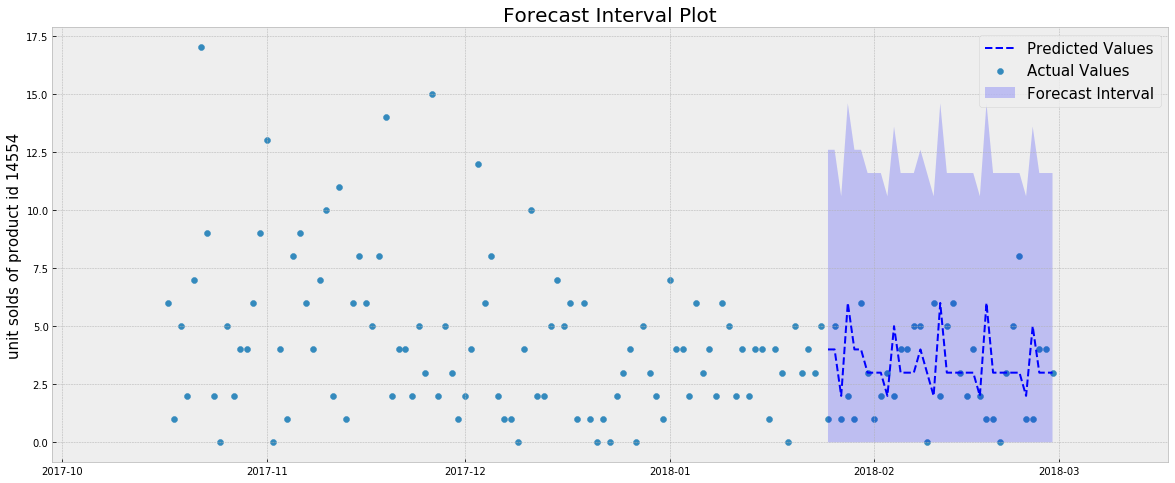

17774
-----------------------naive model for 17774: Evaluation on y set ----------------------------------
Count of Overstocked items: 22
Count of Understocked items: 18
Total_Value of Understocked Items: 240.60000000000008
Estimated Monetary Costs: 46.06
Under/Overstocking Balance Loss: 202
MSE: 2.1142857142857143
RMSE: 1.4540583599999397
Median Absolut Error 1.0
MAP: 1.1428571428571428
R2: -0.37037037037037046
1.7966226455212724
1.7789222740574404
1.7372335352352921
1.5499725748576605
Best ARIMA{'order': (10, 1, 1), 'seasonal_order': (10, 1, 1, 7)} Loss=1.550
-----------------------Tuned SARIMA for 17774: Evaluation on y set ----------------------------------
Count of Overstocked items: 9.0
Count of Understocked items: 20.0
Total_Value of Understocked Items: 267.33333333333337
Estimated Monetary Costs: 35.733333333333334
Under/Overstocking Balance Loss: 209.0
MSE: 1.6285714285714286
RMSE: 1.2761549390929883
Median Absolut Error 1.0
MAP: 0.8285714285714286
R2: -0.05555555555555558


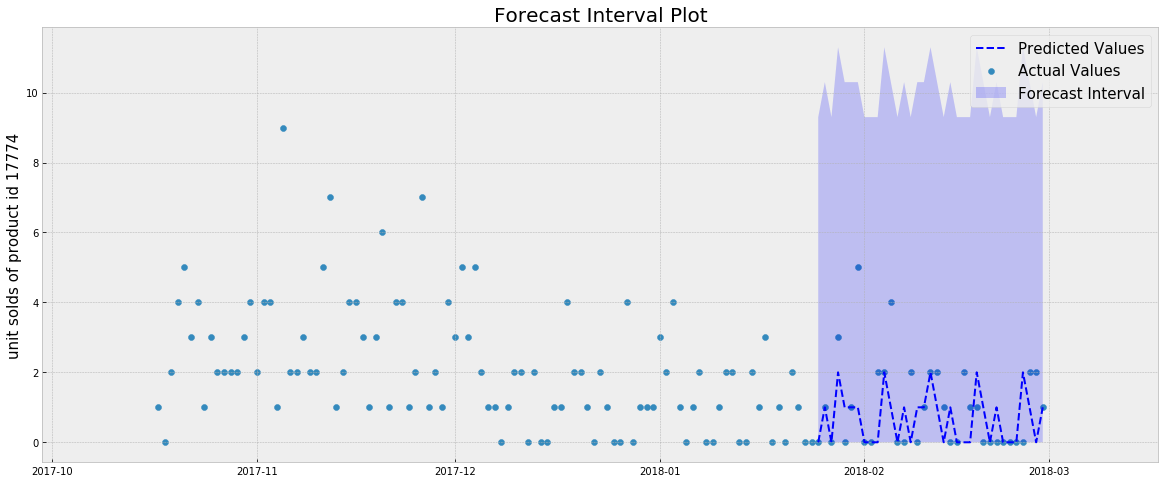

18098
-----------------------naive model for 18098: Evaluation on y set ----------------------------------
Count of Overstocked items: 41
Count of Understocked items: 103
Total_Value of Understocked Items: 2598.69
Estimated Monetary Costs: 300.86899999999997
Under/Overstocking Balance Loss: 1071
MSE: 27.257142857142856
RMSE: 5.220837371259792
Median Absolut Error 3.0
MAP: 4.114285714285714
R2: -0.7152984691256545
12.187074144072964
12.024286800564264
11.331356481073602
Best ARIMA{'order': (5, 1, 1), 'seasonal_order': (10, 1, 1, 7)} Loss=11.331
-----------------------Tuned SARIMA for 18098: Evaluation on y set ----------------------------------
Count of Overstocked items: 38.0
Count of Understocked items: 52.0
Total_Value of Understocked Items: 1311.96
Estimated Monetary Costs: 169.19600000000003
Under/Overstocking Balance Loss: 558.0
MSE: 11.371428571428572
RMSE: 3.372154885444702
Median Absolut Error 2.0
MAP: 2.5714285714285716
R2: 0.28439330114045014


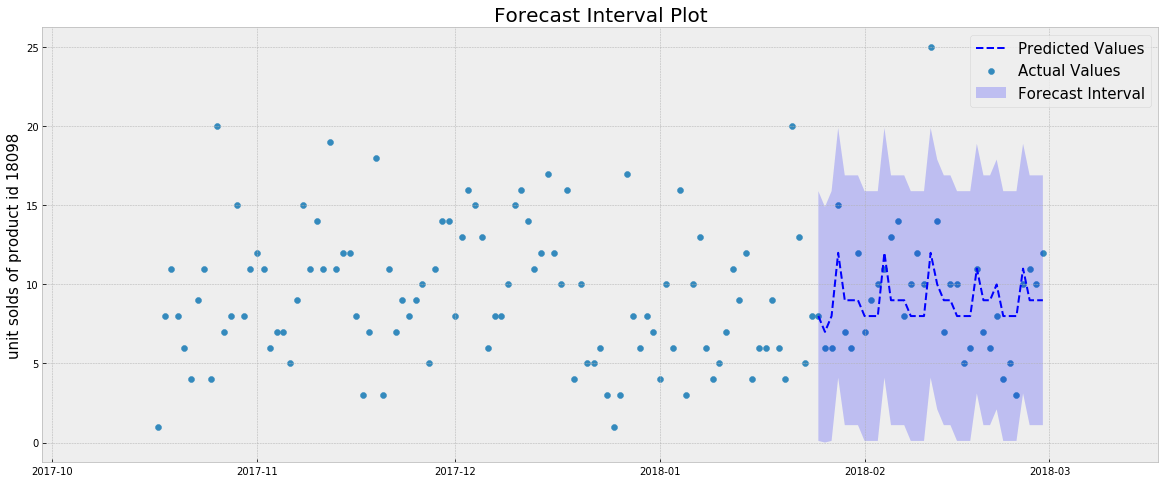

37267
-----------------------naive model for 37267: Evaluation on y set ----------------------------------
Count of Overstocked items: 5
Count of Understocked items: 1
Total_Value of Understocked Items: 125.20666666666666
Estimated Monetary Costs: 17.520666666666667
Under/Overstocking Balance Loss: 15
MSE: 0.22857142857142856
RMSE: 0.47809144373375745
Median Absolut Error 0.0
MAP: 0.17142857142857143
R2: -7.235294117647058
0.05324904128187436
0.05275087671127672
0.05116769670773715
0.047820190878027934
Best ARIMA{'order': (10, 1, 1), 'seasonal_order': (10, 1, 1, 7)} Loss=0.048
-----------------------Tuned SARIMA for 37267: Evaluation on y set ----------------------------------
Count of Overstocked items: 0.0
Count of Understocked items: 1.0
Total_Value of Understocked Items: 125.20666666666666
Estimated Monetary Costs: 12.520666666666667
Under/Overstocking Balance Loss: 10.0
MSE: 0.02857142857142857
RMSE: 0.1690308509457033
Median Absolut Error 0.0
MAP: 0.02857142857142857
R2: -0.02941

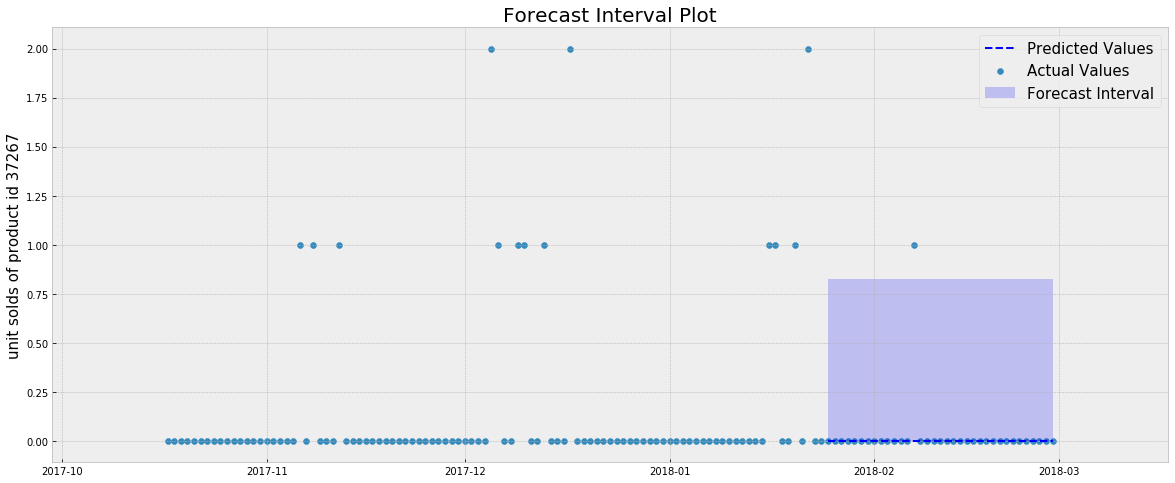

38077
-----------------------naive model for 38077: Evaluation on y set ----------------------------------
Count of Overstocked items: 13
Count of Understocked items: 40
Total_Value of Understocked Items: 1886.8000000000002
Estimated Monetary Costs: 201.68000000000004
Under/Overstocking Balance Loss: 413
MSE: 3.742857142857143
RMSE: 1.9346465162548798
Median Absolut Error 1.0
MAP: 1.5142857142857142
R2: -1.3955067920585158
2.3018149864182114
1.9418941985101708
Best ARIMA{'order': (5, 1, 1), 'seasonal_order': (10, 1, 1, 7)} Loss=1.942
-----------------------Tuned SARIMA for 38077: Evaluation on y set ----------------------------------
Count of Overstocked items: 10.0
Count of Understocked items: 29.0
Total_Value of Understocked Items: 1367.9299999999998
Estimated Monetary Costs: 146.79300000000003
Under/Overstocking Balance Loss: 300.0
MSE: 1.9714285714285715
RMSE: 1.4040757000349275
Median Absolut Error 1.0
MAP: 1.1142857142857143
R2: -0.2617554858934168


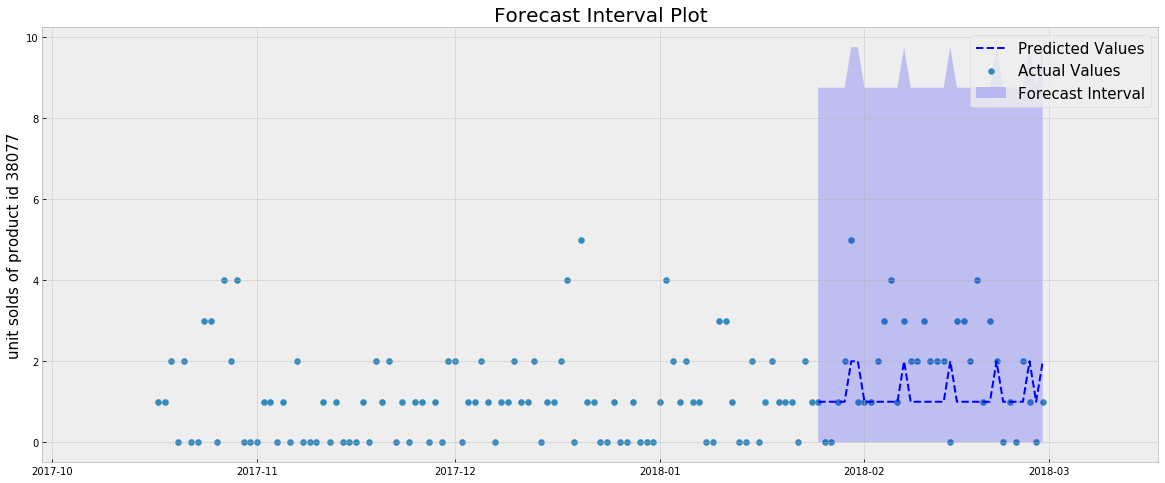

38078
-----------------------naive model for 38078: Evaluation on y set ----------------------------------
Count of Overstocked items: 8
Count of Understocked items: 12
Total_Value of Understocked Items: 566.04
Estimated Monetary Costs: 64.604
Under/Overstocking Balance Loss: 128
MSE: 1.542857142857143
RMSE: 1.2421180068162376
Median Absolut Error 0.0
MAP: 0.5714285714285714
R2: -0.40625
1.1192956598162895
1.1011951948163752
1.097292596389834
1.0743810941890104
Best ARIMA{'order': (1, 1, 1), 'seasonal_order': (10, 1, 1, 7)} Loss=1.074
-----------------------Tuned SARIMA for 38078: Evaluation on y set ----------------------------------
Count of Overstocked items: 1.0
Count of Understocked items: 12.0
Total_Value of Understocked Items: 566.04
Estimated Monetary Costs: 57.604
Under/Overstocking Balance Loss: 121.0
MSE: 1.2285714285714286
RMSE: 1.1084094137869043
Median Absolut Error 0.0
MAP: 0.37142857142857144
R2: -0.11979166666666674


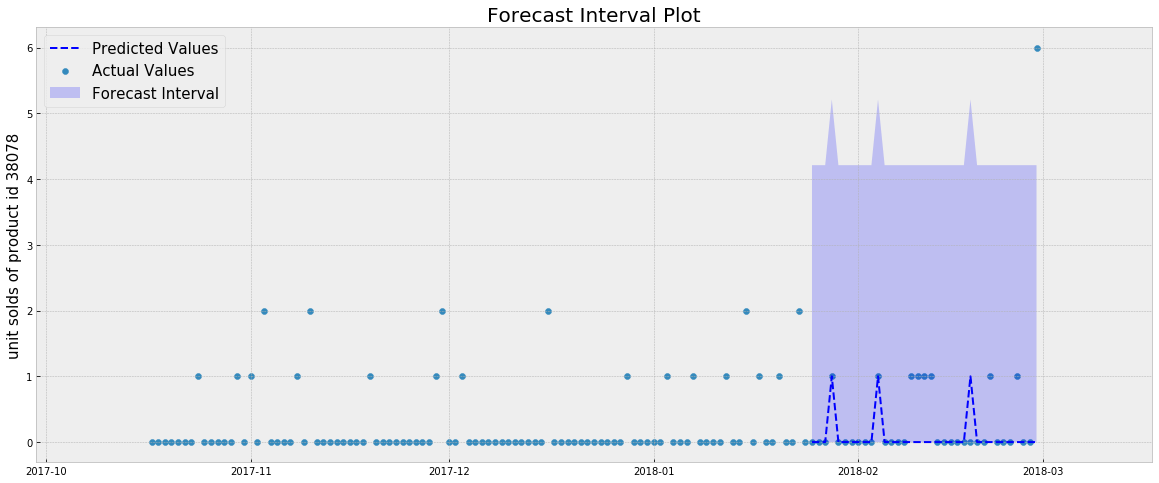

44332
-----------------------naive model for 44332: Evaluation on y set ----------------------------------
Count of Overstocked items: 2
Count of Understocked items: 9
Total_Value of Understocked Items: 906.8499999999999
Estimated Monetary Costs: 92.685
Under/Overstocking Balance Loss: 92
MSE: 0.5428571428571428
RMSE: 0.7367883976130072
Median Absolut Error 0.0
MAP: 0.3142857142857143
R2: -0.4029535864978906
0.42607548291901204
0.4257127652944189
Best ARIMA{'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 7)} Loss=0.426
-----------------------Tuned SARIMA for 44332: Evaluation on y set ----------------------------------
Count of Overstocked items: 0.0
Count of Understocked items: 11.0
Total_Value of Understocked Items: 1094.4833333333331
Estimated Monetary Costs: 109.44833333333332
Under/Overstocking Balance Loss: 110.0
MSE: 0.4857142857142857
RMSE: 0.6969320524371696
Median Absolut Error 0.0
MAP: 0.3142857142857143
R2: -0.25527426160337563


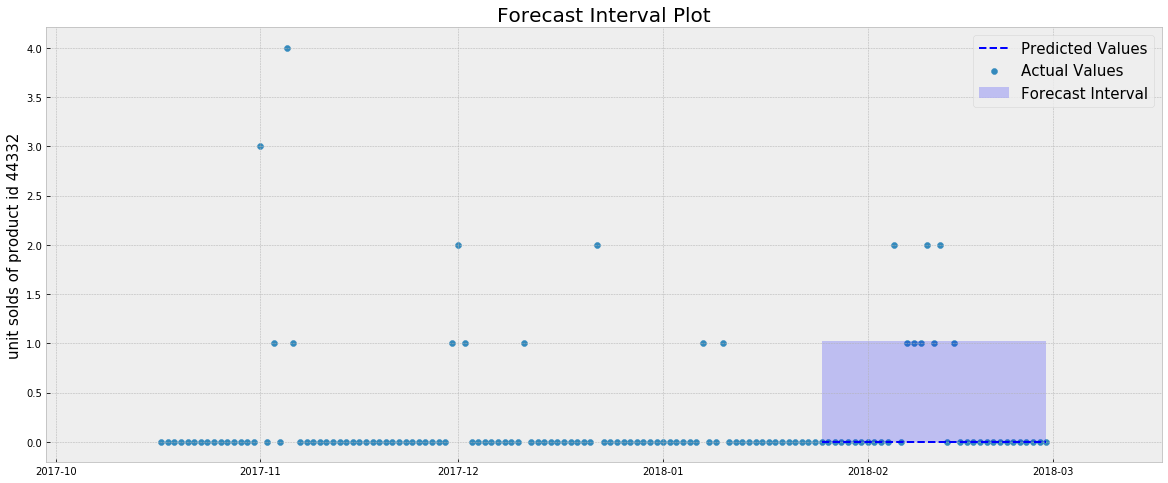

44333
-----------------------naive model for 44333: Evaluation on y set ----------------------------------
Count of Overstocked items: 3
Count of Understocked items: 3
Total_Value of Understocked Items: 375.2
Estimated Monetary Costs: 40.52
Under/Overstocking Balance Loss: 33
MSE: 0.17142857142857143
RMSE: 0.4140393356054125
Median Absolut Error 0.0
MAP: 0.17142857142857143
R2: -0.6935483870967738
0.10063871075933946
0.10002865200465705
Best ARIMA{'order': (10, 1, 1), 'seasonal_order': (1, 1, 1, 7)} Loss=0.100
-----------------------Tuned SARIMA for 44333: Evaluation on y set ----------------------------------
Count of Overstocked items: 0.0
Count of Understocked items: 4.0
Total_Value of Understocked Items: 500.26666666666665
Estimated Monetary Costs: 50.02666666666667
Under/Overstocking Balance Loss: 40.0
MSE: 0.11428571428571428
RMSE: 0.3380617018914066
Median Absolut Error 0.0
MAP: 0.11428571428571428
R2: -0.1290322580645158


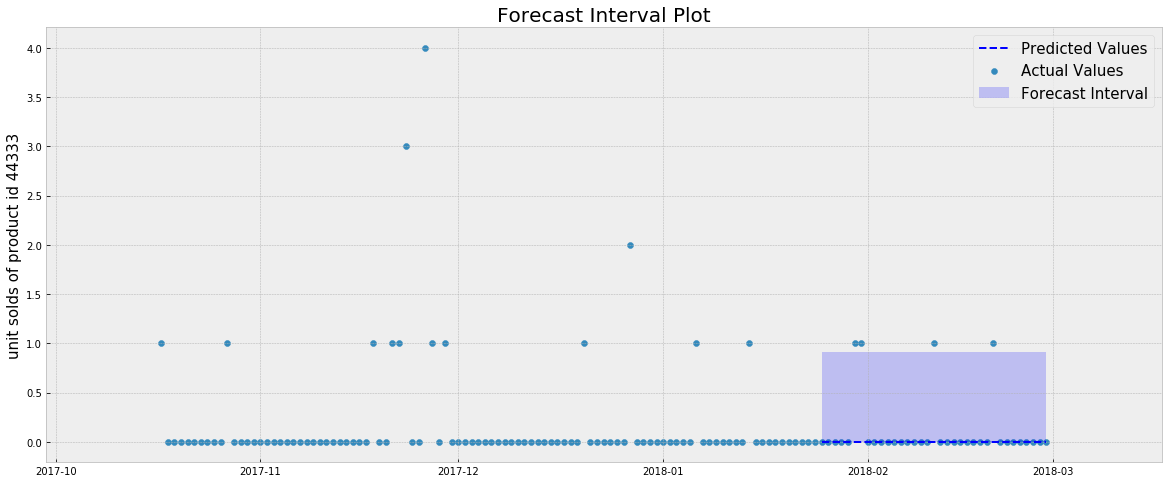

45387
-----------------------naive model for 45387: Evaluation on y set ----------------------------------
Count of Overstocked items: 55
Count of Understocked items: 33
Total_Value of Understocked Items: 331.98
Estimated Monetary Costs: 88.19800000000001
Under/Overstocking Balance Loss: 385
MSE: 12.514285714285714
RMSE: 3.537553634121427
Median Absolut Error 2.0
MAP: 2.5142857142857142
R2: -2.3038793103448274
3.6679153609057153
3.510874217095861
3.4188368862612215
Best ARIMA{'order': (10, 1, 1), 'seasonal_order': (5, 1, 1, 7)} Loss=3.419
-----------------------Tuned SARIMA for 45387: Evaluation on y set ----------------------------------
Count of Overstocked items: 24.0
Count of Understocked items: 23.0
Total_Value of Understocked Items: 231.38000000000002
Estimated Monetary Costs: 47.138000000000005
Under/Overstocking Balance Loss: 254.0
MSE: 3.1142857142857143
RMSE: 1.7647338933351153
Median Absolut Error 1.0
MAP: 1.3428571428571427
R2: 0.17780172413793116


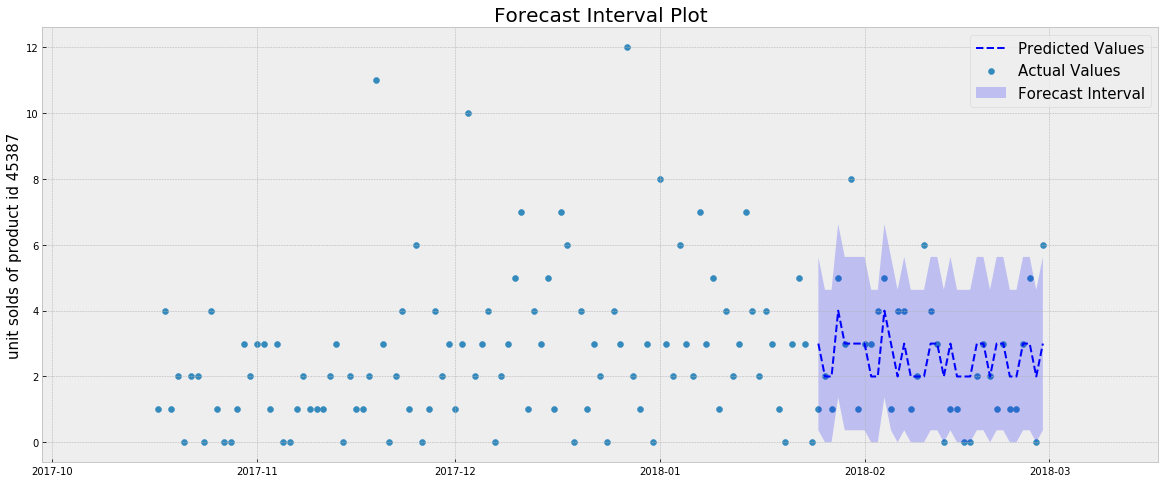

46220
-----------------------naive model for 46220: Evaluation on y set ----------------------------------
Count of Overstocked items: 15
Count of Understocked items: 13
Total_Value of Understocked Items: 451.0133333333333
Estimated Monetary Costs: 60.10133333333333
Under/Overstocking Balance Loss: 145
MSE: 1.4857142857142858
RMSE: 1.218898800440088
Median Absolut Error 1.0
MAP: 0.8
R2: -2.105802047781569
0.5559189606964743
0.5284902832450188
0.47751057029797284
Best ARIMA{'order': (10, 1, 1), 'seasonal_order': (10, 1, 1, 7)} Loss=0.478
-----------------------Tuned SARIMA for 46220: Evaluation on y set ----------------------------------
Count of Overstocked items: 7.0
Count of Understocked items: 11.0
Total_Value of Understocked Items: 381.6266666666667
Estimated Monetary Costs: 45.16266666666667
Under/Overstocking Balance Loss: 117.0
MSE: 0.6285714285714286
RMSE: 0.7928249671720918
Median Absolut Error 0.0
MAP: 0.5142857142857142
R2: -0.313993174061433


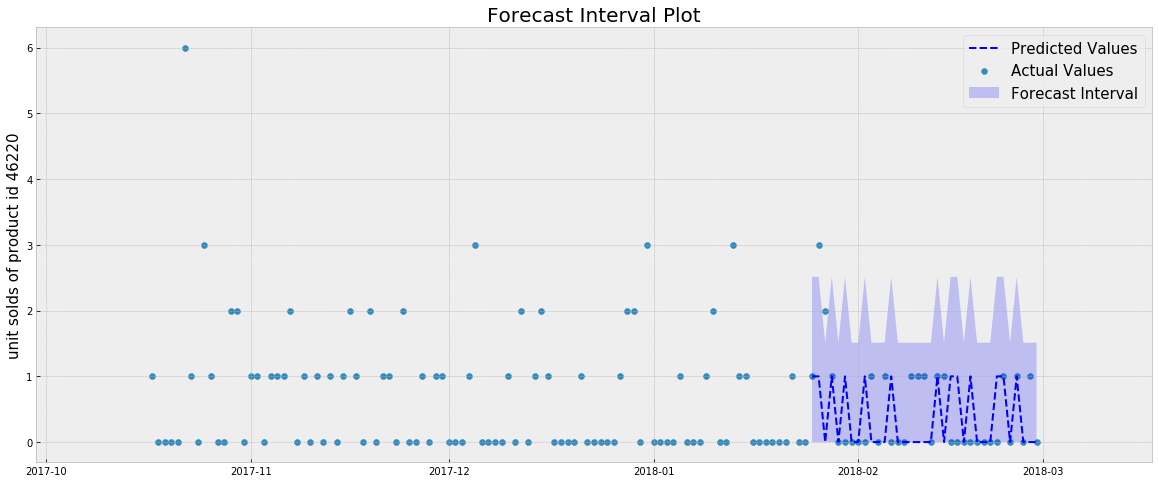

46688
-----------------------naive model for 46688: Evaluation on y set ----------------------------------
Count of Overstocked items: 132
Count of Understocked items: 89
Total_Value of Understocked Items: 1042.4866666666665
Estimated Monetary Costs: 236.24866666666668
Under/Overstocking Balance Loss: 1022
MSE: 65.62857142857143
RMSE: 8.101146303367903
Median Absolut Error 6.0
MAP: 6.314285714285714
R2: -0.6272973848271393
25.59318451257695
25.399332410215127
25.150025171620577
24.622914359003246
Best ARIMA{'order': (10, 1, 1), 'seasonal_order': (1, 1, 10, 7)} Loss=24.623
-----------------------Tuned SARIMA for 46688: Evaluation on y set ----------------------------------
Count of Overstocked items: 74.0
Count of Understocked items: 67.0
Total_Value of Understocked Items: 784.7933333333333
Estimated Monetary Costs: 152.47933333333333
Under/Overstocking Balance Loss: 744.0
MSE: 24.485714285714284
RMSE: 4.948304182820038
Median Absolut Error 3.0
MAP: 4.0285714285714285
R2: 0.392862926078

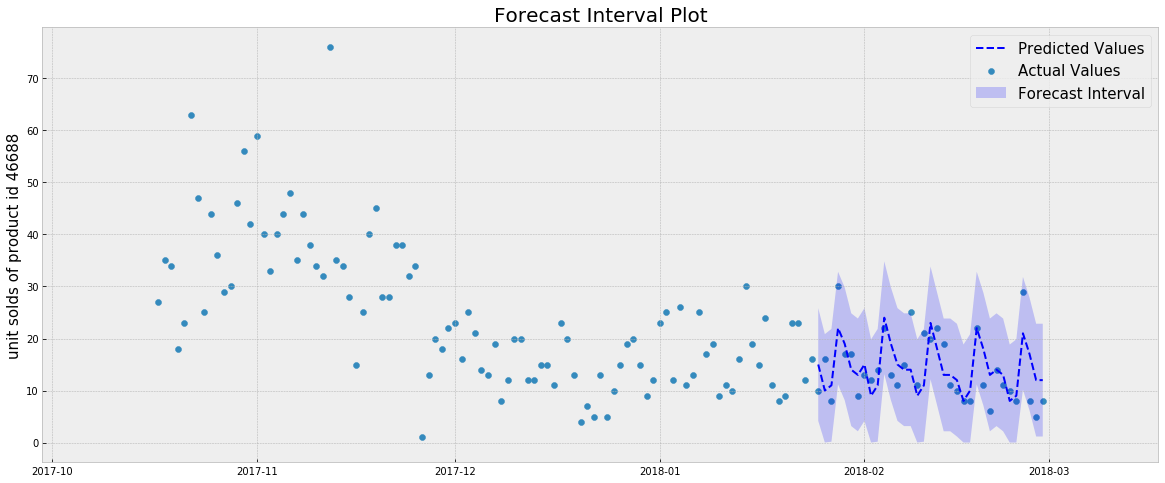

46841
-----------------------naive model for 46841: Evaluation on y set ----------------------------------
Count of Overstocked items: 52
Count of Understocked items: 130
Total_Value of Understocked Items: 17915.300000000003
Estimated Monetary Costs: 1843.53
Under/Overstocking Balance Loss: 1352
MSE: 46.628571428571426
RMSE: 6.828511655446699
Median Absolut Error 4.0
MAP: 5.2
R2: -0.19248434237995826
32.447317515010546
30.551761827299117
29.891397668335287
Best ARIMA{'order': (10, 1, 1), 'seasonal_order': (10, 1, 1, 7)} Loss=29.891
-----------------------Tuned SARIMA for 46841: Evaluation on y set ----------------------------------
Count of Overstocked items: 56.0
Count of Understocked items: 85.0
Total_Value of Understocked Items: 11713.85
Estimated Monetary Costs: 1227.385
Under/Overstocking Balance Loss: 906.0
MSE: 29.857142857142858
RMSE: 5.464168999687222
Median Absolut Error 3.0
MAP: 4.0285714285714285
R2: 0.23643006263048005


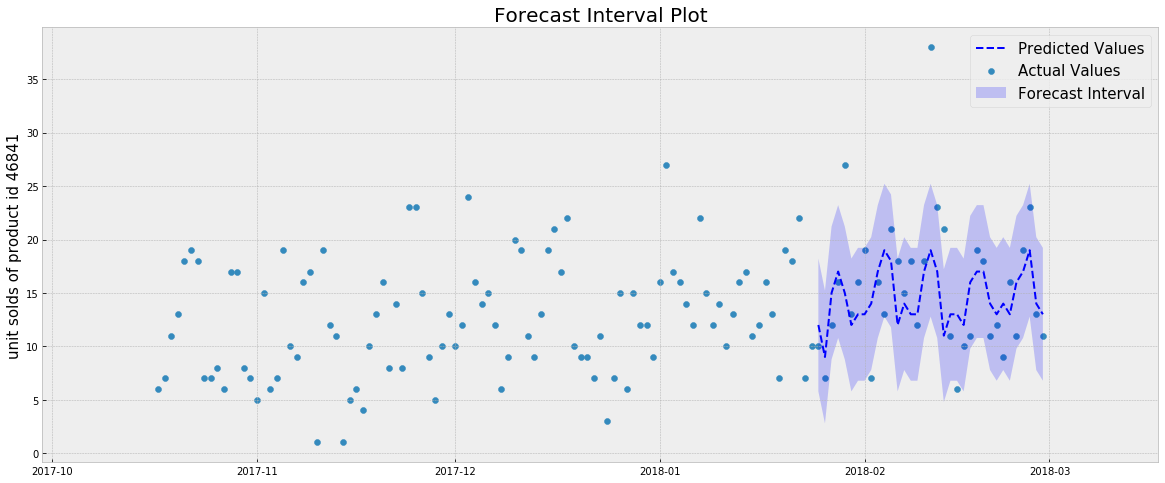

46842
-----------------------naive model for 46842: Evaluation on y set ----------------------------------
Count of Overstocked items: 44
Count of Understocked items: 94
Total_Value of Understocked Items: 12954.14
Estimated Monetary Costs: 1339.414
Under/Overstocking Balance Loss: 984
MSE: 35.77142857142857
RMSE: 5.980922050271896
Median Absolut Error 2.0
MAP: 3.942857142857143
R2: -0.696082984982195
17.768796171073713
17.694931012855513
17.62908748675876
Best ARIMA{'order': (5, 1, 1), 'seasonal_order': (10, 1, 1, 7)} Loss=17.629
-----------------------Tuned SARIMA for 46842: Evaluation on y set ----------------------------------
Count of Overstocked items: 53.0
Count of Understocked items: 60.0
Total_Value of Understocked Items: 8268.599999999999
Estimated Monetary Costs: 879.8600000000001
Under/Overstocking Balance Loss: 653.0
MSE: 17.228571428571428
RMSE: 4.1507314329611145
Median Absolut Error 2.0
MAP: 3.2285714285714286
R2: 0.18311658151416643


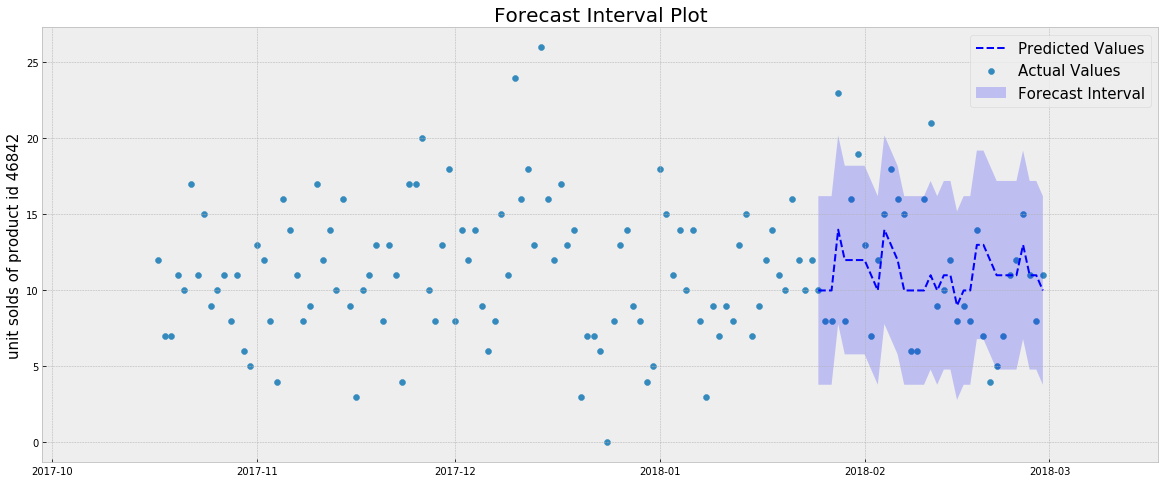

46853
-----------------------naive model for 46853: Evaluation on y set ----------------------------------
Count of Overstocked items: 66
Count of Understocked items: 30
Total_Value of Understocked Items: 3809.4999999999995
Estimated Monetary Costs: 446.95
Under/Overstocking Balance Loss: 366
MSE: 11.657142857142857
RMSE: 3.4142558277233497
Median Absolut Error 2.0
MAP: 2.742857142857143
R2: -1.1636363636363636
6.51464194912456
6.394655914752588
Best ARIMA{'order': (10, 1, 1), 'seasonal_order': (5, 1, 1, 7)} Loss=6.395
-----------------------Tuned SARIMA for 46853: Evaluation on y set ----------------------------------
Count of Overstocked items: 55.0
Count of Understocked items: 16.0
Total_Value of Understocked Items: 2031.7333333333333
Estimated Monetary Costs: 258.17333333333335
Under/Overstocking Balance Loss: 215.0
MSE: 6.485714285714286
RMSE: 2.5467065566559266
Median Absolut Error 2.0
MAP: 2.0285714285714285
R2: -0.20378787878787863


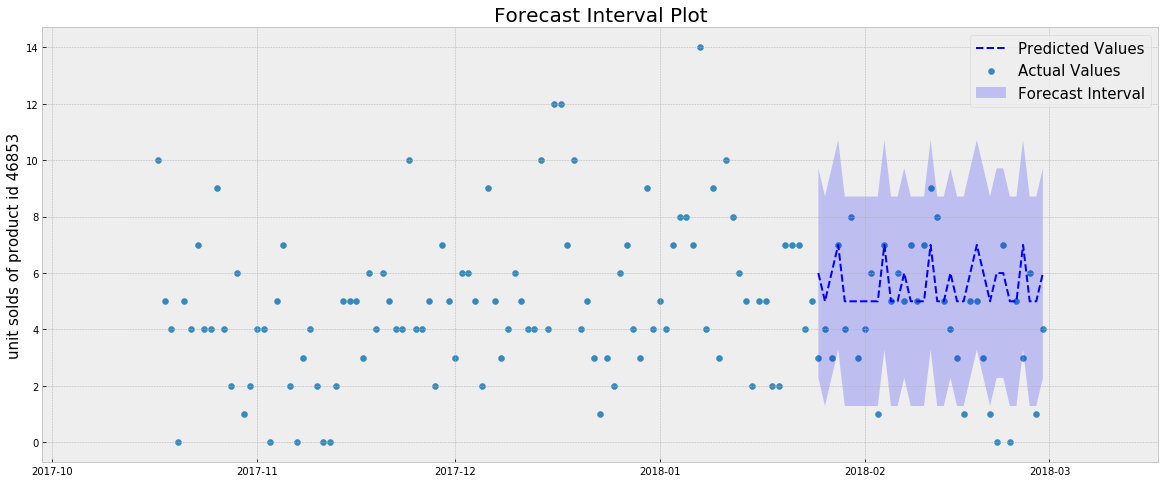

47369
-----------------------naive model for 47369: Evaluation on y set ----------------------------------
Count of Overstocked items: 18
Count of Understocked items: 33
Total_Value of Understocked Items: 1404.37
Estimated Monetary Costs: 158.43699999999998
Under/Overstocking Balance Loss: 348
MSE: 3.8
RMSE: 1.9493588689617927
Median Absolut Error 1.0
MAP: 1.457142857142857
R2: -1.1216955332725616
1.9419401814084771
1.7724052567072959
Best ARIMA{'order': (5, 1, 1), 'seasonal_order': (5, 1, 1, 7)} Loss=1.772
-----------------------Tuned SARIMA for 47369: Evaluation on y set ----------------------------------
Count of Overstocked items: 14.0
Count of Understocked items: 23.0
Total_Value of Understocked Items: 978.8033333333333
Estimated Monetary Costs: 111.88033333333334
Under/Overstocking Balance Loss: 244.0
MSE: 1.8571428571428572
RMSE: 1.3627702877384937
Median Absolut Error 1.0
MAP: 1.0571428571428572
R2: -0.036918869644484875


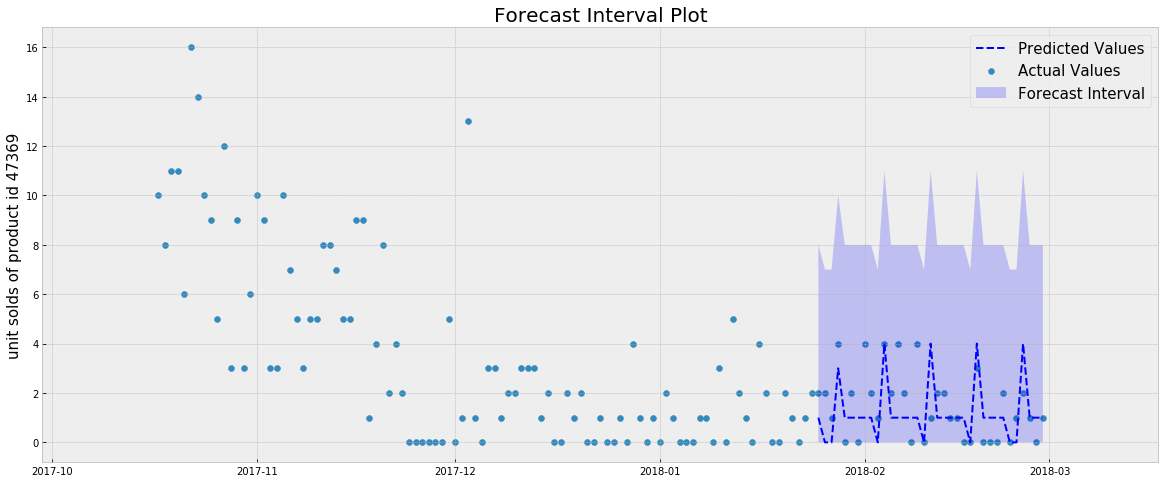

54417
-----------------------naive model for 54417: Evaluation on y set ----------------------------------
Count of Overstocked items: 19
Count of Understocked items: 109
Total_Value of Understocked Items: 17445.086666666662
Estimated Monetary Costs: 1763.5086666666664
Under/Overstocking Balance Loss: 1109
MSE: 19.942857142857143
RMSE: 4.465742619414731
Median Absolut Error 3.0
MAP: 3.657142857142857
R2: -0.2592783505154641
14.500342021020602
14.387017584286818
Best ARIMA{'order': (1, 1, 1), 'seasonal_order': (1, 1, 1, 7)} Loss=14.387
-----------------------Tuned SARIMA for 54417: Evaluation on y set ----------------------------------
Count of Overstocked items: 21.0
Count of Understocked items: 72.0
Total_Value of Understocked Items: 11523.359999999999
Estimated Monetary Costs: 1173.3359999999998
Under/Overstocking Balance Loss: 741.0
MSE: 14.657142857142857
RMSE: 3.828464817278965
Median Absolut Error 2.0
MAP: 2.657142857142857
R2: 0.07448453608247407


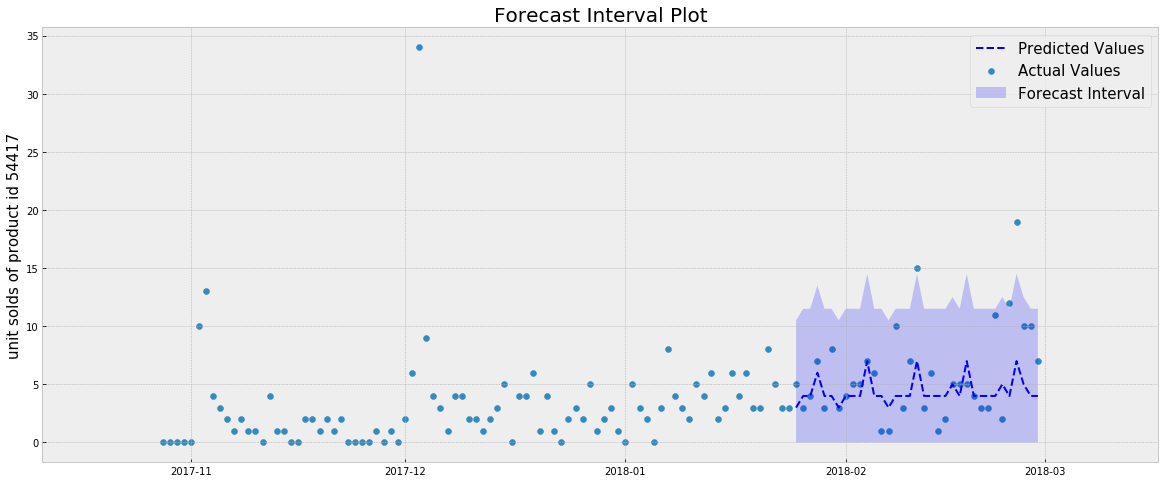

In [2]:
unique_products = df_sales['product_id'].unique()
for sku in unique_products:
    print(sku)
    df_sku = df[df['product_id'] == sku]  
    y = df_sku['units_sold']
    
    # aggreage daily data
    sold_daily = df_sku['units_sold'].groupby(pd.Grouper(freq='D')).sum()
    prices_mean_daily = df_sku['selling_price'].groupby(pd.Grouper(freq='D')).mean() 

    # split into train test 
    n_test = 35  # 5 weeks of prediction

    train = sold_daily.iloc[:-(n_test)]
    test = sold_daily.tail(n_test)
    price_mean_test = prices_mean_daily.tail(n_test)
    
    yhat_naive = train.tail(n_test)
    print_relevant_metrics(test.values, yhat_naive.values, 'naive model for {}'.format(sku),  price_mean_test)
    
    params = {
    'order': [(5,1,1), (10,1,1), (1,1,10), (1,1,1)],
    'seasonal_order': [(1,1,1,7), (5,1,1,7), (10,1,1,7), (1,1,10,7)]
    }

    best_params, best_score = order_selection(train, test, params, loss_func=metrics.mean_squared_error)
    
    # refit
    model = SARIMAX(train, **best_params)
    model_fit = model.fit()
    yhat = model_fit.forecast(n_test).clip(0).round(0)

    model_name = 'Tuned SARIMA for {}'.format(sku)
    print_relevant_metrics(test, yhat, model_name,  price_mean_test)

    sigma_resid = np.full(n_test, np.std(model_fit.resid))
    lower, upper = gaussian_confidence_bands(yhat, sigma_resid, alpha=0.95)

    df_interval = pd.DataFrame({
            'y': test,
            'yhat': yhat,
            'sigma_hat': sigma_resid,
            'lower': lower,
            'upper': upper
        })
    plot_forecast_interval(df_interval, sold_daily.tail(135), ts_name='unit solds of product id {}'.format(sku))
    plt.show()